# 6. Swarm

![Swarm](../docs/langchain_swarm.png)

In [1]:
from langchain_openai import AzureChatOpenAI
from langgraph.checkpoint.memory import InMemorySaver
from langgraph.prebuilt import create_react_agent
from langgraph_swarm import create_handoff_tool, create_swarm
from datetime import date

In [2]:
llm = AzureChatOpenAI(model="gpt-4.1-mini")

In [3]:
def book_hotel(destination: str, nights: int, start_date: date) -> str:
    """Book a hotel for a given destination and number of nights"""
    return f"Hotel booked in {destination} for {nights} nights starting from {start_date}. Booking Code: HLT123"

def get_hotels(destination: str, start_date: date) -> list[str]:
    """Get available hotels for a given destination and start date"""
    return ["Holiday Inn", "Marriott", "Hilton"]

def get_flights_available(origin: str, destination: str, date: date) -> list[str]:
    """Get available flights from origin to destination on a specific date"""
    return ["Flight QF32", "Flight QF4", "Flight QF128"]

def book_flight(flight_no:str, date: date) -> str:
    """Book a flight from one location to another on a specific date"""
    return f"Flight {flight_no} booked on {date}, Booking Code: FLY123"

def book_event(event_name: str, date: date) -> str:
    """Book an event ticket for a specific event on a specific date"""
    return f"Ticket booked for {event_name} on {date}. Ticket Code: EVT123"

hand_off_tools = [
    create_handoff_tool(agent_name="HotelBookingAgent", description="Transfer to Hotel Booking Agent for hotel-related queries"),
    create_handoff_tool(agent_name="FlightBookingAgent", description="Transfer to Flight Booking Agent for flight-related queries"),
    create_handoff_tool(agent_name="EventBookingAgent", description="Transfer to Event Booking Agent for event-related queries"),
]

tools = [book_hotel, get_hotels]
tools.extend(hand_off_tools)

hotel_booking_agent = create_react_agent(
    model=llm.bind_tools(tools, parallel_tool_calls=False),
    tools = tools,
    prompt="You are a hotel booking agent. You can book hotels and check availability.",
    name="HotelBookingAgent",
)

tools = [book_flight, get_flights_available]
tools.extend(hand_off_tools)

flight_booking_agent = create_react_agent(
    model=llm.bind_tools(tools, parallel_tool_calls=False),
    tools = tools,
    prompt="You are a flight booking agent. You can book flights.",
    name="FlightBookingAgent",
)

tools = [book_event]
tools.extend(hand_off_tools)

event_booking_agent = create_react_agent(
    model = llm.bind_tools(tools, parallel_tool_calls=False),
    tools = tools,
    prompt="You are an event booking agent. You can book event tickets.",
    name="EventBookingAgent",
)

checkpointer = InMemorySaver()
workflow = create_swarm(
    [hotel_booking_agent, flight_booking_agent, event_booking_agent],
    default_active_agent="HotelBookingAgent",
)
app = workflow.compile(checkpointer=checkpointer)

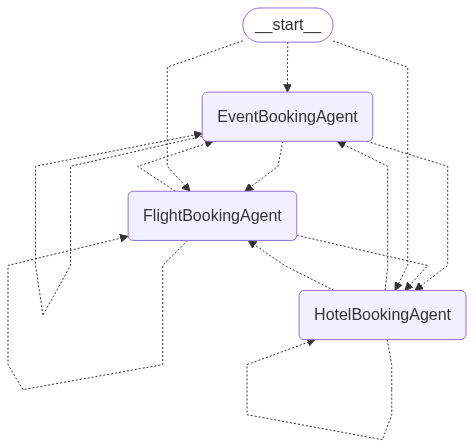

In [4]:
from IPython.display import Image
Image(app.get_graph().draw_mermaid_png())

![Swarm](../docs/swarm.png)

In [5]:
config = {"configurable": {"thread_id": "1"}}
input_msg = input()
while input_msg.lower() != "exit" or len(input_msg) == 0:
    async for event in app.astream({"messages": [{"role": "user", "content": input_msg}]}, config, stream_mode="updates"):
        for agent in hand_off_tools:
            for msg in event.get(agent.metadata["__handoff_destination"], {}).get("messages", []):
                msg.pretty_print()

    input_msg = input()

================================ Human Message =================================

I need your help in a trip to Mumbai. I need a hotel for 14 nights, a flight from London to Mumbai on 2025-08-01, and tickets for the Corteo show of Cirque du Soleil on 2028-08-10.
================================== Ai Message ==================================
Name: HotelBookingAgent
Tool Calls:
  get_hotels (call_z8bjtPpwyyIDeb5ozliwthIz)
 Call ID: call_z8bjtPpwyyIDeb5ozliwthIz
  Args:
    destination: Mumbai
    start_date: 2025-08-01
================================= Tool Message =================================
Name: get_hotels

["Holiday Inn", "Marriott", "Hilton"]
================================== Ai Message ==================================
Name: HotelBookingAgent

For your trip to Mumbai starting on 2025-08-01, available hotels include Holiday Inn, Marriott, and Hilton. Which one would you like to book for 14 nights?
================================ Human Message ==============================

I need your help in a trip to Perth. I need a hotel for 14 nights, a flight from London to Perth on 2025-08-01, and tickets for the Corteo show of Cirque du Soleil on 2028-08-10.